In [29]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import time

In [64]:
class Dragonfly:
    def __init__(
        self, 
        x: np.array(float), 
        f: float
             ):
        self.x = x
        self.f = f
        
class DragonflySwarm:
    def __init__(
        self,
        swarm_size: int,
        dim: int,
        max_iter: int,
        sep: float,
        alignmnt: float,
        cohesn: float,
        tendnsy: float,
        evatn: float,
        weight: float, 
        alpha: float,
        lmbd: float,
        radius: float,
        step_modification: int,
        const_for_modif: float
        #area: List[List[float]],
                 ):
        self.swarm_size = swarm_size
        self.dim = dim
        self.u_dim = dim - 1
        self.max_iter = max_iter
        self.current_iter = 0
        self.sep = sep
        self.alignmt = alignmnt
        self.cohesn = cohesn
        self.tendnsy = tendnsy
        self.evatn = evatn
        self.weight = weight
        self.alpha = alpha
        self.lmbd = lmbd
        self.radius = radius
        self.population = []
        self.sep_list = np.zeros(self.u_dim)
        self.alig_list = np.zeros(self.u_dim)
        self.coh_list = np.zeros(self.u_dim)
        self.food_attract = np.zeros(self.u_dim)
        self.enemy_avoid = np.zeros(self.u_dim) #было array
        self.velocity_list = []# np.zeros(self.u_dim)
        self.euclid_list = []
        self.best_list = []
        self.worst_list = []
        self.exact = 0
        self.best_x1 = []
        self.best_x2 = []
        self.const_for_modif = 0.5#const_for_modif
        self.step_modification = step_modification
    
    
    def init_area(self, control):
        self.area = [np.array([0, 1]) for i in range(control.N_step - 1)] #deleted np.array(*)
        self.exact = control.ExactI()

               
    # the dims are ok now -  the problem was at the dragonfly constructor
    def form_first_pop(self, control):
        self.population.clear()
        for i in range(self.swarm_size):
            coordinate = np.array([np.random.rand() * (self.area[j][1] - self.area[j][0]) + self.area[j][0] 
                          for j in range(self.dim - 1)])
            #print(coordinate)
            result = control.Functional(coordinate)
            #print(result)
            member = Dragonfly(coordinate, result)
            self.population.append(member)
            
    def form_first_test(self, control):
        self.population.clear()
        coordinate = [14.85362988, 10.0884234,  91.26533093,  4.16710264]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [14.08606978, 33.57488406, 15.50686803, 14.23677781]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [24.16833537,  5.4091227,  86.42287235, 77.04554707]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [14, 10,  91,  4]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        coordinate = [1, 3, 15, 14]
        result = control.Functional(coordinate)
        member = Dragonfly(coordinate, result)
        self.population.append(member)
        
    def test_form(self, control):
        #tst - это u
        tst = [10, 3]
        result = control.Functional(tst)
        member = Dragonfly(tst, result)
        self.population.append(member)   
        tst = [2, 5]
        result = control.Functional(tst)
        member = Dragonfly(tst, result)
        self.population.append(member)   
        tst = [4, 7]
        result = control.Functional(tst)
        member = Dragonfly(tst, result)
        self.population.append(member) 

        

    def generate_step_coord(self):
        self.velocity_list.clear()
        for i in range(self.swarm_size):
            #rj = np.random.uniform(-1, 1)
            velocty = [(self.area[j][1] - self.area[j][0]) * np.random.uniform(-1, 1) / 100
                for j in range(self.u_dim)]
            #print(velocty)
            tmp = np.zeros(self.u_dim)
            for ind in range(self.u_dim):
                tmp[ind] = velocty[ind]
            self.velocity_list.append(tmp)
            
    def move_swarm(self, control):
        self.current_iter += 1
        right_area = False # same as "flag" in a previous C# code 
        
        radius_area = self.radius * self.current_iter / self.max_iter
        trunk_ = self.max_iter - self.max_iter // 2
        
        population_copy = self.population.copy()
        velocity_copy = self.velocity_list.copy()
        
        for i in range(self.swarm_size):
            for j in range(self.swarm_size):
                if i != j:
                    dist = np.linalg.norm(np.array(population_copy[i].x) -
                                          np.array(population_copy[j].x))
                    if dist <= radius_area:
                        self.euclid_list.append([j, dist])
            
            if len(self.euclid_list) > 1:
                #print('Formula')
                self.sep_list = self.separation(i, population_copy)
                self.alig_list = self.alignment(i, velocity_copy)
                self.coh_list = self.cohesion(i, population_copy)
                self.food_attract = self.tendensy(i, population_copy)
                self.enemy_avoid = self.evation(i, population_copy)
                #выходит за пределы массива в скорости 25 из 24
                tmp_velo = np.zeros(self.u_dim)
                tmp_velo = self.velocity(i)
                self.velocity_list[i] = tmp_velo #self.velocity_list.append(self.velocity(i))
                
                if (self.current_iter < trunk_):
                    tmp_list = self.find_new_position(i)
                    #print(tmp_list)
                else:
                    tmp_list = self.find_new_position_mod(i, self.step_modification)
                
                
                for ii in range(self.u_dim):
                    #не так все равно tmp_list вектор или вектор векторов?
                    self.population[i].x[ii] = tmp_list[ii]
                self.check_area(i)
            else:
                half_set = int((self.u_dim) / 2)
                r_parameter = []
                theta = []
                l_parameter = []
                xi_parameter = []
                
                
                for ii in range(self.u_dim):
                    iterator_0 = 0
                    while not right_area:
                        r_parameter.append(np.random.rand() * (self.area[ii][1] - self.area[ii][0]) + self.area[ii][0])
                        theta.append(r_parameter[len(r_parameter) - 1] * 2 * np.pi)
                        l_parameter.append(r_parameter[len(r_parameter) - 1] ** self.lmbd)
                        
                        if ii < half_set:
                            xi_parameter.append(l_parameter[len(l_parameter) - 1] * np.sin(theta[len(theta) - 1]))
                        else:
                            xi_parameter.append(l_parameter[len(l_parameter) - 1] * np.cos(theta[len(theta) - 1]))
                                                
                        check_obl = np.array(self.population[i].x[ii]) + \
                        (self.alpha / (self.current_iter + 1)) * xi_parameter[len(xi_parameter) - 1]
                        if (check_obl < self.area[ii][0]) or (check_obl > self.area[ii][1]):
                            right_area = False
                            if iterator_0 > 100:
                                check_obl = np.abs(check_obl) / 2
                                right_area = True
                                break      
                        else:
                            right_area = True
                        iterator_0 += 1
                    right_area = False
                    self.population[i].x[ii] = (self.population[i].x[ii]) + \
                        (self.alpha / (self.current_iter + 1)) * xi_parameter[len(xi_parameter) - 1]
                    #print(self.population[i].x)
                
            self.population[i].f = control.Functional(self.population[i].x)
            self.euclid_list.clear()
            
    def separation(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        #print(len(self.euclid_list))
        for indx, dist in self.euclid_list:
            tmp += (np.array(population_copy[it].x) - np.array(population_copy[indx].x))
            #print(tmp)
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] /= 10
            if(tmp[i] >= (area_tmp/2)):
                tmp[i] = tmp[i] / 2
            tmp[i] = -tmp[i]
        return tmp
    
    def alignment(self, it, velocity_copy):
        tmp = np.zeros(self.u_dim)
        for indx, dist in self.euclid_list:
            tmp_velo = np.array(velocity_copy[indx])
            tmp += tmp_velo
        tmp = tmp / len(self.euclid_list)
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(tmp[i] >= (area_tmp/2)):
                tmp[i] = tmp[i] / 2
        return tmp
    
    def cohesion(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        for indx, dist in self.euclid_list:
            tmp += np.array(population_copy[indx].x)
        tmp = tmp / len(self.euclid_list) - np.array(population_copy[it].x)
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(tmp[i] >= (area_tmp/2)):
                tmp[i] = tmp[i] / 2
        return tmp
    
    def tendensy(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        best_p = max(population_copy, key=lambda member: member.f)
        tmp = np.array(best_p.x) - np.array(population_copy[it].x)
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(tmp[i] >= (area_tmp/2)):
                tmp[i] = tmp[i] / 2
        return tmp
    
    def evation(self, it, population_copy):
        tmp = np.zeros(self.u_dim)
        worst_p = min(population_copy, key=lambda member: member.f)
        tmp = np.array(worst_p.x) + np.array(population_copy[it].x)
        for i in range(self.u_dim):
            area_tmp = self.area[i][1] - self.area[i][0]
            while (np.abs(tmp[i]) >= area_tmp):
                tmp[i] = tmp[i] / 10
            if(tmp[i] >= (area_tmp/2)):
                tmp[i] = tmp[i] / 2
        return tmp
    
    def velocity(self, it):
        S = self.sep * np.array(self.sep_list)
        A = self.alignmt * np.array(self.alig_list)
        C = self.cohesn * np.array(self.coh_list)
        F = self.tendnsy * np.array(self.food_attract)
        E = self.evatn * np.array(self.enemy_avoid)
        W = self.weight * np.array(self.velocity_list[it])
        tmp_velocity = S + A + C + F + E + W
        #self.velocity_list[it] = S + A + C + F + E + W
        return tmp_velocity
#         self.velocity_list[it] = self.sep * np.array(self.sep_list[it]) + self.alignmt * np.array(self.alig_list[it]) + self.cohesn * np.array(self.coh_list[it]) +\
#         self.tendnsy * np.array(self.food_attract[it]) + self.evatn * np.array(self.enemy_avoid[it]) + self.weight * np.array(self.velocity_list[it])
    
    def find_new_position(self, it):
        tmp = np.zeros(self.dim)
        tmp = np.array(self.population[it].x) + np.array(self.velocity_list[it])
        return tmp
    
    def find_new_position_mod(self, it, modif):
        tmp = np.zeros(self.dim)
        if modif == 0:
            tmp = np.array(self.population[it].x) + np.array(self.velocity_list[it]) / it
        elif modif == 1:
            tmp = np.array(self.population[it].x) + np.array(self.velocity_list[it]) / m.log(it+2)
        elif modif == 2:
            tmp = np.array(self.population[it].x) + np.array(self.velocity_list[it]) * m.log(0.8) / m.log(it+2)
        elif modif == 3:
            tmp = np.array(self.population[it].x) + np.array(self.velocity_list[it]) * m.exp((self.const_for_modif - 1) * it)
        elif modif == 4:
            tmp = np.array(self.population[it].x) + np.array(self.velocity_list[it])
        return tmp
            
    def check_area(self, i):
        if (self.population[i].x[0] < self.area[0][0]):
            self.population[i].x[0] = self.area[0][0]
        elif (self.population[i].x[0] > self.area[0][1]):
            self.population[i].x[0] = self.area[0][1]
        
        if (self.population[i].x[1] < self.area[1][0]):
            self.population[i].x[1] = self.area[1][0]
        elif (self.population[i].x[1] > self.area[1][1]):
            self.population[i].x[1] = self.area[1][1]
#         for i in range(self.u_dim):
#             if (self.population[it].x[i] < self.area[i][0]):
#                 self.population[it].x[i] = self.area[i][0]
            
#             if (self.population[it].x[i] > self.area[i][1]):
#                 self.population[it].x[i] = self.area[i][1]
    
    
    def find_best(self):
        return max(self.population, key=lambda dragonfly: dragonfly.f)
    
    def find_worst(self):
        return min(self.population, key=lambda dragonfly: dragonfly.f)
    
    def Work(self, control):
        start = time.monotonic()
        time.sleep(0.1)
        
        self.init_area(control)
        self.form_first_pop(control)
        self.generate_step_coord()

        best = self.find_best()
        tmp = np.zeros(self.u_dim)
        for i in range(self.u_dim):
             tmp[i] = best.x[i]     
        member_temp = Dragonfly(tmp, best.f)
        self.best_list.append(member_temp)
        
        worst = self.find_worst()
        tmp = np.zeros(self.u_dim)
        for i in range(self.u_dim):
             tmp[i] = best.x[i]
        member_temp = Dragonfly(tmp, worst.f)
        self.worst_list.append(member_temp)
        
        
        for i in range(self.max_iter):
            
            self.move_swarm(control)
            
            tmp = np.zeros(self.u_dim)
            best_temp = self.find_best()
            
            for j in range(self.u_dim):
                tmp[j] = best_temp.x[j]
            member_temp = Dragonfly(tmp, best_temp.f)
            self.best_list.append(member_temp)
            
            tmp = np.zeros(self.u_dim)
            worst_temp = algorithm.find_worst()
            for j in range(self.u_dim):
                tmp[j] = worst_temp.x[j]
            member_temp = Dragonfly(tmp, worst_temp.f)
            self.worst_list.append(member_temp)
            
        self.best_list.sort(reverse=True, key=lambda dragonfly: dragonfly.f)
        self.worst_list.sort(key=lambda dragonfly: dragonfly.f)
        #print(self.best_list[0].f, self.worst_list[0].f)
        #list(self.best_list[0].x).sort(reverse=True)
        end = time.monotonic()
        self.make_best_x(self.best_list[0].x)
        self.draw_plots()
        print('Approximate =', self.best_list[0].f,'Exact = ', self.exact, '  Error = ', (self.exact-self.best_list[0].f)
             )
        print('work time : {:>9.2f}'.format(end-start))
        #относительная погрешность
    
    def make_best_x(self, u):
        self.best_x1.clear()
        self.best_x2.clear()
        self.best_x1.append(0)
        self.best_x2.append(0)
        for i in range(1, self.dim):
            tmp_x1 = self.best_x2[i - 1]
            tmp_x2 = 2 * self.best_x2[i - 1] - self.best_x1[i - 1] + 1 / (self.dim**2) * u[i - 1]
            self.best_x1.append(tmp_x1)
            self.best_x2.append(tmp_x2)
        self.best_x1 = np.array(self.best_x1)
        self.best_x2 = np.array(self.best_x2)
    
    def draw_plots(self):
        plt.figure(figsize=(18, 6))

        #list_sorted = list(self.best_list[0].x)
        #list_sorted.sort()
        #list_sorted.reverse()
        plt.subplot(1,3,1)
        #plt.plot(list_sorted)
        plt.plot(self.best_list[0].x, '.')
        plt.ylabel('u')
        plt.xlabel('t')

        plt.subplot(1,3,2)
        plt.plot(self.best_x1, '.')
        plt.ylabel('$x_{1}$')
        plt.xlabel('t')

        plt.subplot(1,3,3)
        plt.plot(self.best_x2, '.')
        plt.ylabel('$x_{2}$')
        plt.xlabel('t')

        plt.show()
            

In [65]:
class DiscreteSystem:
    def __init__(
    self, 
    N_step: int,
    ):
        self.N_step = N_step # N is the dimention of the x, dim for u is the N-1
        self.u_min = 0
        self.u_max = 100

    def make_x(self, u):
        x1 = []
        x2 = []
        x1.append(0)
        x2.append(0)
        for i in range(1, self.N_step):
            tmp_x1 = x2[i - 1]
            tmp_x2 = 2 * x2[i - 1] - x1[i - 1] + 1 / self.N_step**2 * u[i - 1]
            x1.append(tmp_x1)
            x2.append(tmp_x2)
        x1 = np.array(x1)
        x2 = np.array(x2)
        return x1, x2

    def Functional(self, u):
        x1 = []
        x2 = []
        x1, x2 = self.make_x(u)
        x1 = np.array(x1)
        x2 = np.array(x2)
        #print(x1)
        #print(x2)
        #print('-----------------------------------')
        #print(x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2))
        return x1[len(x1) - 1] - 1 / (2 * self.N_step) * sum(np.array(u)**2)
        
        
    def ExactI(self):
        return 1/3 - (3 * self.N_step - 1) / (6 * self.N_step**2) - 1 / (2 * self.N_step**3) * sum([t**2 for t in range(self.N_step)])

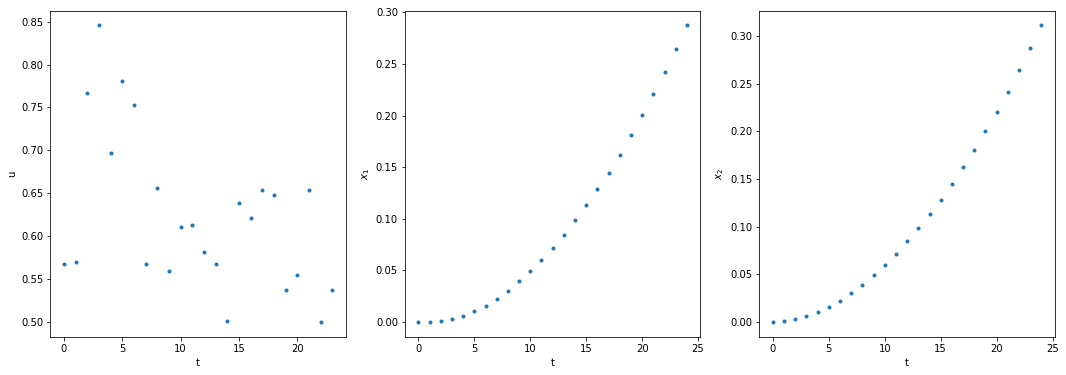

Approximate = 0.09653059661638061 Exact =  0.1568   Error =  0.060269403383619385
work time :     17.04


In [73]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(150, a.N_step, 50, 0.1, 0.1, 0.7, 0.1, 0.6, 0.9, 1, 1, 100000, 3, 0.5)
algorithm.Work(a)

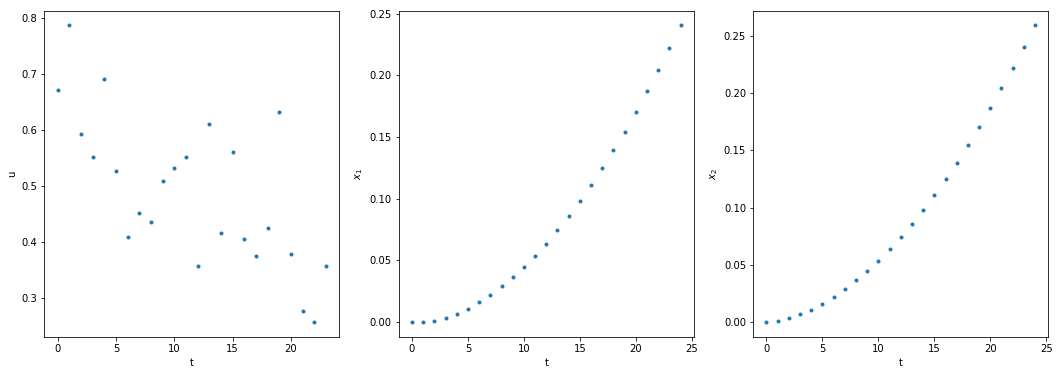

Approximate = 0.11677393732487924 Exact =  0.1568   Error =  0.04002606267512075
work time :   1531.27


In [75]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(1700, a.N_step, 50, 0.01, 0.01, 0.07, 0.1, 0.1, 0.09, 1, 1, 100000, 3, 0.5)
algorithm.Work(a)

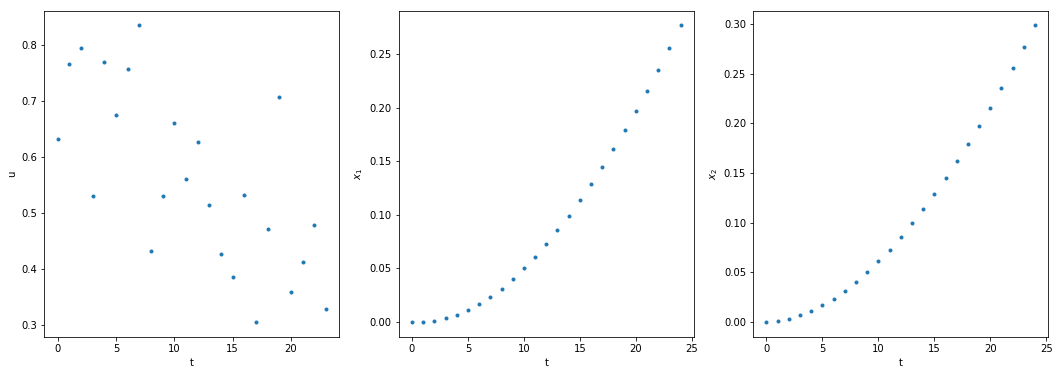

Approximate = 0.1135535831483441 Exact =  0.1568   Error =  0.043246416851655894
work time :     65.52


In [72]:
a = DiscreteSystem(25)
algorithm = DragonflySwarm(180, a.N_step, 150, 0.01, 0.01, 0.07, 0.1, 0.1, 0.09, 1, 1, 100000, 3, 0.5)
algorithm.Work(a)

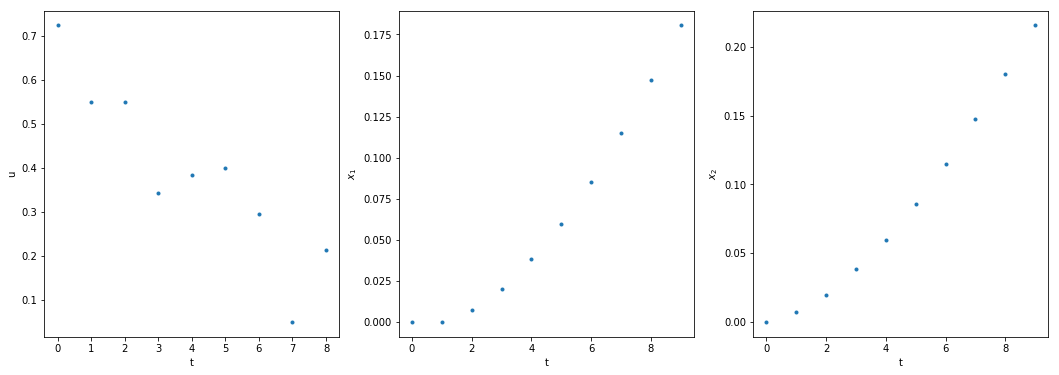

Approximate = 0.09588994582665092 Exact =  0.14249999999999996   Error =  0.04661005417334904
work time :   2303.95


In [78]:
a = DiscreteSystem(10)
algorithm = DragonflySwarm(2000, a.N_step, 50, 0.01, 0.01, 0.07, 0.1, 0.1, 0.09, 1, 1, 100000, 3, 0.5)
algorithm.Work(a)

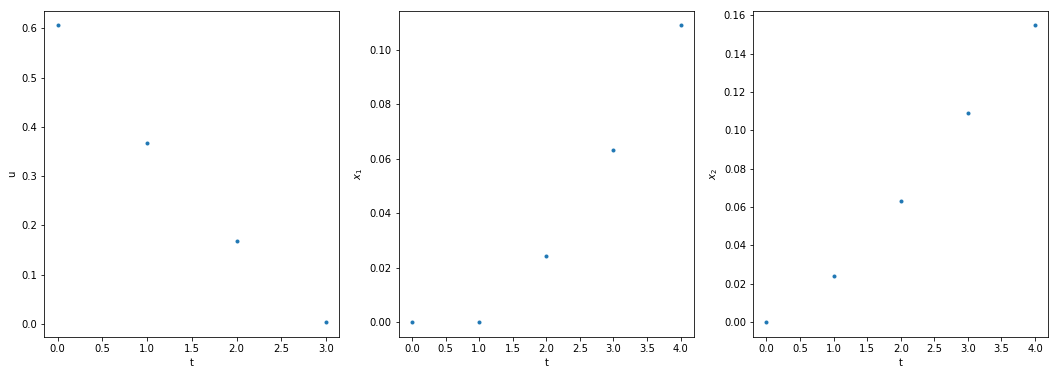

Approximate = 0.055795172942573086 Exact =  0.12   Error =  0.06420482705742692
work time :   2331.28


In [79]:
a = DiscreteSystem(5)
algorithm = DragonflySwarm(2000, a.N_step, 50, 0.01, 0.01, 0.07, 0.1, 0.1, 0.09, 1, 1, 100000, 3, 0.5)
algorithm.Work(a)